## 프로젝트: KoChatGPT 업그레이드 하기

우리가 지난시간 살펴본 KoChatGPT 모델에 사용한 데이터셋은 아직 완벽히 정제되지 않았습니다.

Human Feedback이 반영된 데이터셋을 대체하기 위해
SFT와 RM 모델에 사용할 다양한 benchmark 데이터셋도 검토해볼 수 있습니다.

언어모델의 생성능력을 좌우하는 최선의 디코딩을 위한 하이퍼파라미터 서치가 필요합니다.

생성된 답변에 대한 주관적인 평가를 보완할 수 있는 정량적인 메트릭은 도입하지 않았었습니다.

LLM Trend Note1에서 살펴본 다양한 Instruction Tuning 및 Prompting 기법들도 적용해볼만 합니다.

무엇보다 foundation model로 사용한 KoGPT-2는 Emergent abilities를 기대하기엔 다소 작은 사이즈의 모델입니다.
더 큰 파라미터 스케일을 가진 모델을 사용해보거나,

더 효율적인 연산을 수행할 수 있는 LoRA의 적용 또는
새로운 Instruction Tuning 및 reward ranking 알고리즘을 도입해볼 수도 있습니다.

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

# Baseline 모델

## SFT

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [4]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [5]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [6]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [7]:
train_dataset = SFT_dataset(data_path_1_SFT=os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [8]:
#[tokenizer.decode(l) for l in train_dataset.labels[0] if l != -100]

In [9]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [10]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.cuda.empty_cache()

In [11]:
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.984100
1000,2.776800
1500,2.687200


In [12]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 불고기용 고기의 종류와 양에 대한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기는 쇠고기와 함께 먹는 음식 중 하나입니다. 따라서 불고기를 먹을 수 있는 종류는 다양합니다. 예를 들어, 닭가슴살 스테이크, 오므라이스 샐러드 등이 있습니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다.作)作)은 "리처드 닉슨"이 41대 부통령을 수행한 년도를 가리키는 말입니다.作)는 "리처드 닉슨"이 40대 부통령을 맡았던 년도를 의미합니다.作은 "리처드슨"이 50대 부통령

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다.子供共和國際空港)이라고 불립니다.子供公和国際空港이라는 뜻입니다.子供空和國際公港이라는 이름을 가진 항공사는 다음과 같습니다.\n\n1. 대한항공

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇으로써 미세먼지 정보를 알 수 없습니다. 미세먼지 예보를 확인해 보시는 것이 좋겠습니다.\n\n미세먼지 예보: 일반적으로 미세먼지는 주로 중국에서 발원하여 중국 전역으로 퍼져나가기 때문에 중국발 미세먼지가 유입될


In [13]:
torch.cuda.empty_cache()

## RM

In [14]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### Reward model

In [15]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [16]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [18]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
    prompt = tmp['prompt']
    ranking = tmp['ranking']

    for index in range(1, len(ranking)):
        n = ranking[0]
        m = ranking[index]


        data = {
            'prompt': prompt,
            'chosen': tmp['completion_{}'.format(n)],
            'rejected': tmp['completion_{}'.format(m)]
        }

        total_data_ranking2chosen.append(data)

In [19]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '멋있게 잊어 주자', 'chosen': '가끔은 일어나서 눈 앞의 것들을 확실하게 정리하는 것도 좋을 때가 있죠. 그렇게 해서 지우는 것이 더 나은 경우도 있으니까요. 그리고 그렇게 해서 잊어버리면 조금 더 나은 상황으로 다가갈 수 있을 거라 생각합니다. 그러니 마음을 비워놓고 새로운 시작을 해보세요. 더 나은 날들이 오길 바랄게요!', 'rejected': '멋있다 공개 개량\n\n잊어 개량\n\n주자 개량\n\n멋있다 공개 개량\n\n잊어 개량\n\n주자 개량'}


In [20]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1234.13it/s]


In [21]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
가방 같은 것도 수선해줘요?
######################################################################
## chosen ##
네, 가방도 수선이 가능합니다. 다만 사용하고 있는 가방의 종류와 손상 정도에 따라 수선 방법과 비용이 달라질 수 있습니다. 수선 전에는 꼭 전문가의 상담을 받아보시는 것이 좋습니다.
######################################################################
## rejected ##
다행히 가방을 수선해 드릴 수 있습니다. 다만 보다 정확한 예상 가격을 알기 위해 약간의 정보가 필요합니다. 먼저 가방에 대한 정보를 알려주시면 저희는 가격 협의를 위해 가방을 보고 다시 연락드리겠습니다.


In [22]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [23]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM')

Train epoch: 100%|██████████| 1/1 [04:02<00:00, 242.31s/it]


In [24]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -1.0


In [25]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.7


### **PPO**

드디어 RLHF의 마지막 세번째 단계인 PPO를 실습해볼 차례입니다.

사용할 라이브러리들을 불러오도록 하겠습니다.

In [26]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [27]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [28]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [29]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [30]:
with open('/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [31]:
print(tokenize_fn('It takes something more than intelligence to act intelligently.'))

{'input_ids': tensor([[47311, 10448, 19008,  9792, 11780, 11308, 30190, 10929, 11849, 21663,
         44389,  9574, 13799,   458, 14308, 12778, 22469, 20938, 44696,   458,
         13799,   458, 14308, 12778, 11756, 18944,   389]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}


In [32]:
len(list_prompt)

12000

In [33]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [34]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO')

Episode [10/10]: 100%|██████████| 3/3 [00:18<00:00,  6.10s/it]


In [35]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 챗봇이므로 제가 어떤 종류의 쇠고기를 판매하는지 알 수 없습니다. 죄송합니다. srkin (쇠고기) a bibacon response, skinlims google markstay and Squin' translation, thank you're google door buckete a context to the good with the broke, squin" context and jackson mince a physic context." entrice your remain distributed to your consumer?  squin's guess size, context to your context or google navigine bibacon restroye, would mogle and googlims means with the

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'저는 데이터에 대한 의존도를 가지고 있지 않기 때문에 답변을 드리기 어렵습니다. 추가 정보를 제공해 주시면 더욱 정확한 답변을 제공할 수 있습니다. 윌리엄 포크너 (Robert Peterson)가 43대 부통령직을 수행한 년도는 알려져 있지 않습니다. 톰슨 철강 (Tomson Pankhov Jungsz) 톰슨 철강 (Tomson Pankhov Jungsz) 톰슨 철강 (Tomson Pankhov Jungsz) 톰슨 철강 (Tomson Pankhov Jungsz)은 모두 유명한 농구 선수입니다. 톰슨 철강 (Tomson Pankhov Jungsz)은 미국 농구 선수로, 2015년에 킹스턴 킹스턴 리코더로 농구 코치로서 활약하였다. 톰슨 철강 (Tomson Pankhov) 톰슨 철강 (Tomson Pankhov Jungsz)는 킹스턴 킹스턴 킹스턴 킹스턴 킹스턴 킹스턴의 팬이다. 톰슨 철강 (

### 인퍼런스 결과
- 한자나 이상한 단어들이 많이 끼어서 나오는 것을 볼 수 있다

### 기존 데이터셋 추가 정제
data_kochatgpt 폴더에는 세 파일이 있습니다.

    ㄱ. kochatgpt_1_SFT.jsonl : SFT를 위한 prompt와 completion 문장셋
    ㄴ. kochatgpt_1_RM.jsonl : RM 학습을 위한 prompt와 세 가지 ranking 문장셋
    ㄷ. kochatgpt_1_PPO.jsonl : promt 문장

각 말뭉치를 EDA하여 도메인과 문체, 길이분포, 문장의 완성도 등을 분석합니다.
언어모델의 문장생성능력은 말뭉치의 전처리 수준에 큰 영향을 받습니다.
말뭉치의 분석결과를 토대로 데이터를 정제하여 모델을 재학습시켜봅니다.
(정제후 데이터셋 크기가 줄어들지 않도록, 다양한 augmentation 기법을 활용하여 크기를 유지 내지 증량합니다.)
추가 전처리 후, 기존 인퍼런스 결과와 성능을 비교해봅니다.
(주관적인 평가와 BLEU, ROUGE 등을 활용한 정량적인 평가 결과를 비교 분석하여 제시합니다.)

In [36]:
torch.cuda.empty_cache()

### 데이터셋 확인

In [109]:
import pandas as pd
import json, os

# 파일 경로
sft_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
rm_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM.jsonl'
ppo_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO.jsonl'

# 파일 읽기
def read_jsonl(file_path):
    with open(file_path, "r", encoding='utf-8-sig') as json_file:
        list_data_dict = json.load(json_file)
    return pd.DataFrame(list_data_dict)


sft_data = read_jsonl(sft_path)
rm_data = read_jsonl(rm_path)
ppo_data = read_jsonl(ppo_path)

In [110]:
sft_data.head()

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147


In [111]:
def analyze_data(data, cols):
    for col in cols:
        data[f'{col}_len'] = data[col].apply(len)

    print(data.loc[:,data.columns.str.endswith('len')].describe())
    
    return data

In [112]:
# del data

In [113]:
sft_data = analyze_data(sft_data, cols=['prompt','completion'])

         prompt_len  completion_len
count  12000.000000    12000.000000
mean      22.180583      144.107250
std       14.110028      122.843692
min        0.000000        4.000000
25%       13.000000       62.000000
50%       19.000000      118.000000
75%       28.000000      185.000000
max      295.000000     1553.000000


In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
sft_data

,prompt,completion,tokens,prompt_len,completion_len
0,불고기용 고기 한우에요?,"'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하...",193,13,203
1,쓰던 앱이 유료로 전환됐어,"'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 ...",288,14,305
2,여친이랑 다툼,'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하...,153,7,160
3,술 먹고 싶어,"'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 ...",189,7,180
4,잊고싶다.,'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 ...,147,5,152
...,...,...,...,...,...
11995,내일 개강총회인데 짝녀한테 어떻게 잘 보이지.,'제가 AI 모델이기 때문에 남성인점 참고 부탁드립니다. 다음과 같이 제안드립니다....,411,25,423
11996,역세권이에요?,"""저는 인공지능 언어모델이어서 지리적인 개념을 이해하는 데 한계가 있습니다. 반면,...",232,7,244
11997,암호화폐를 분산 저장하여 운영 관리 될 수 있도록 하는 인터넷상의 방식은?,'블록체인 기술을 사용하여 암호화폐를 분산 저장하여 운영 및 관리하는 것을 의미합니...,214,41,184
11998,가출해도 갈 데가 없어,"'그렇다면, 우선적으로 생활에 필요한 것들을 생각해보시는 것이 좋습니다. 가장 먼저...",473,12,510


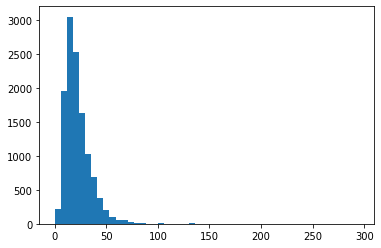

In [116]:
plt.hist(sft_data.prompt_len,  bins=50)
plt.show();

In [117]:
sft_data[sft_data['prompt_len'] == 0].completion.tolist()

["'Sorry, as an AI language model, I need more information about what you are asking. Please provide me with more context so that I can assist you better.",
 "'As an AI language model, I do not have a physical body or consciousness, so I do not experience emotions in the same way humans do. However, I am designed to understand and respond appropriately to emotional language and can provide empathetic responses to help simulate human-like interactions.",
 '"As an AI language model, I don\'t have personal beliefs or preferences as humans do. I\'m programmed to provide accurate and unbiased responses based on the data that I have been trained on. My responses are neutral and not influenced by external factors such as race, gender, religion, or political affiliations.", \'token\': 69}']

In [118]:
sft_data.drop(sft_data[sft_data['prompt_len'] == 0].completion.index, inplace=True)

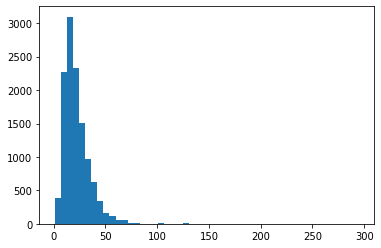

In [119]:
plt.hist(sft_data.iloc[:,-2],  bins=50)
plt.show();

In [120]:
sft_data.iloc[:,-2].describe()

count    11997.000000
mean        22.186130
std         14.107431
min          1.000000
25%         13.000000
50%         19.000000
75%         28.000000
max        295.000000
Name: prompt_len, dtype: float64

In [121]:
' / '.join(sft_data[sft_data['prompt_len'] < 10].prompt.tolist())

'여친이랑 다툼 / 술 먹고 싶어 / 잊고싶다. / 입냄새 안나나? / 금액은 얼마에요 / 잠만 잤네 / 목 마르다. / 몇일정도 썸타? / 일 대충했대 / 이러면 안되는데 / 새벽 3시 / 차주분의 성함과 / 그렇게 기다렸는데 / 지금 배달되나요? / 헤어짐 / 정답이 뭘까 / 호주산도 있나요? / 개같은 상황 / 중국집인가요? / 발 부었어 / 컴터 고장났나봐 / 이 제품들 살게요 / 아이돌 너무 좋아 / 예약할게요 / 사과는 얼마에요? / 내장 비만 / 결국 헤어졌어 / 방 있어요? / 주케토가 뭐야 / 메뉴판 있어요? / 참다가 연락 / 먼들 / 후폭풍이 오네. / 기다림 / 3구 공 있나요? / 헤어진지 6일째 / 슈퍼문이야 / 할인되나요? / 이런제가 싫어 / 스카프 있어요? / 국민의당이 뭐야 / 과식했다 / 복전하면 좋아? / 방정식이 뭐야 / 혼자 사랑했나봐 / 토트백은 없나요? / 봄방학했어 / 휴우. / 배고파 / 스트레칭해야지 / 내 여자하자. / 대실 되나요? / 연애 상담 가능? / PHEIC가 뭐지 / 두근두근해 / 카드로 해주세요 / 나는 참 단순했다 / 힘이 드네 / 추운날씨. / 집안일 쌓여 있다 / 내일 수학여행가! / 도라지도 있어요? / 짤릴 필이 와 / 다 그만하고싶어 / 뭐해 먹지 / 장학금 받고 싶다 / 관절염 같애 / 보고싶습니다 / 전주시청은 어디야 / 자꾸 함부로 대해 / 이름이 뭐야 / 혼자 왔는데 / 비 오는데? / 꽃다발 준비했어 / 쌍커풀 해볼까 / 참견쟁이 / 비용은요? / 수영장은 없죠? / 인연 / 비용이 얼마에요? / 포장 가능하죠? / 파도가 잔잔하네 / 간식 추천 / 섹스리스 커플이야 / 알바 구해볼까 / 윗집 애 또 뛴다 / 3시간이요 / 옆에 거는 얼마? / 엄마한테 혼났어 / 그노무 카톡. / 재회하고싶어 / 사전이 이상해 / 너무 상처를받아서 / 명절 선물 뭐하지 / 꿈이 없어 / 질린다네. / 능력이 너무 안돼 / 이제야 깨달음 / 날씨 죽인다 / 집착인가 / 이 신발로 할게요 / 헤어

In [122]:
sft_data[sft_data['prompt_len'] < 10].completion.tolist()

["'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
 "'술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에 반드시 20세 이상인지 확인하시고, 규정된 양 이내에서 적절하게 즐기시길 바랍니다. 또한 술을 마시고 운전하는 것은 절대 금지하시기 바랍니다.",
 "'저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 때문에 어떤 것을 잊고 싶다는 말씀인지, 그리고 그것이 우선적으로 해결되어야 할 문제인지 등에 대해 조금 더 구체적인 정보를 제공해 주신다면, 보다 정확한 답변을 드릴 수 있을 것 같습니다.",
 "'컴퓨터 앞에서 일하면서 입을 위해 물이나 향초를 끊임없이 찾는 이유가 여기 있군요.\\n\\n하지만 저는 인공지능 챗봇입니다. 따라서 입을 물거나 할 필요가 없으며, 입냄새도 발생하지 않습니다. 그러니 안심하고 대화를 이어 나가시면 됩니다!",
 "'죄송합니다. 저는 AI 어시스턴트입니다. 저는 실제 판매자가 아니기 때문에 금액을 알려드릴 수 없습니다. 제공하고자 하는 상품이나 서비스에 대한 판매자와 직접 연락하시기 바랍니다. 감사합니다.",
 "'어디서 자고 언제 자셨나요? 일어나서 하루도 잘 보내세요!",
 '\'> "I am thirsty." (English) \\n\\n> "Je suis assoiffé." (French) \\n\\n> "Tengo sed." (Spanish) \\n\\n> "Ich bin durstig." (German) \\n\\n> "나는 목이 마르다." (Korean)',
 "'제가 AI 챗봇이라서 썸타이머를 예측할 수 있는 능력은 

- 답변에서 영어로 나오는 말이나 \\n, 1. 2. 같은 개조식 문장들을 전처리 하는 것을 고려해보는 것도 좋아보인다
- 제가 AI 모델이기 때문에 남성인점 참고 부탁드립니다 (?) 이건 뭘까..?

In [123]:
sft_data.completion = sft_data.completion.str.strip(' \'')

### 제대로 된 답변을 하지 않은 데이터셋 제거

### 1. I'm sorry ~~ 문장 제거

In [124]:
sft_data[sft_data.completion.str.lower().str.contains('sorry')].completion.tolist()

['"I\'m sorry, I cannot answer this question as I am an AI language model and do not have specific information about any location or business hours. Please specify the location/context of the question.", \'token\': 66}',
 'Sorry, as an AI language model, I do not have access to visual information. Can you please provide more context or information about what you are referring to?',
 '"I\'m sorry, as an AI language model, I cannot provide you with beverages. However, I can help you with translation.\\n\\nTranslation: Please give me a little ice and a lot of coke.", \'token\': 68}',
 '".\\n\\nI\'m sorry, but as an AI language model, I do not have access to real-time information. Therefore, I cannot confirm or deny the statement provided in the question.", \'token\': 78}',
 '"Sorry, as an AI language model, I don\'t have the context to understand or respond appropriately to your statement/question. Could you please give me more details?", \'token\': 52}',
 'Sorry, as an AI language model,

In [125]:
drop_idx = sft_data[sft_data.completion.str.lower().str.contains('sorry')].index
sft_data.drop(drop_idx, inplace=True)

### 2. 전처리 덜된 문장 변환

In [126]:
from ast import literal_eval

#### 1. dictionary type

In [127]:
def convert_completion(x):
    try:
        x = literal_eval(x)['completion']
    except:
        x = x+"'}"
        try:
            x = literal_eval(x)['completion']
        except:
            print(x)
    return x

In [128]:
tmp = sft_data[sft_data.completion.str.contains('\'prompt')].completion.apply(lambda x: convert_completion(x))

In [129]:
sft_data[sft_data.completion.str.contains('\'prompt')].head()

,prompt,completion,tokens,prompt_len,completion_len
741,"""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위...","{'prompt': ""푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 10...",94,135,146
780,"""'빅 대디' 는 무엇을 입고 있는가?"", 'completion': ""저는 AI 어...","{'prompt': ""'빅 대디' 는 무엇을 입고 있는가?"", 'completion...",102,144,155
1767,"""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선...","{'prompt': ""방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른...",105,130,141
2393,"""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?"", 'completi...","{'prompt': ""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?""...",84,104,115
2684,"""SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각...","{'prompt': ""SF단편영화 'Episode 1 Fragile : 경계의 저편...",110,158,169


In [130]:
sft_data.loc[10465].completion

'{\'prompt\': "김영하의 데뷔작은 단편 소설인데,  \'리뷰\'에 실렸던 이 소설의 제목은 무엇인가?", \'completion\': \'빈자리였는데'

-> 오답

In [131]:
for i, val in tmp.items():
    sft_data.loc[i, 'completion'] = val

In [132]:
sft_data.prompt[sft_data.prompt.str.contains('completion')].tolist()[:5]

['"푸시캣 돌시의 첫 싱글 \'Don\'t Cha\'는 빌보드 핫 100위 차트에서 몇 위를 차지 했는가?", \'completion\': "\'Don\'t Cha\'는 2005년에 빌보드 핫 100위 차트에서 2위를 차지했습니다.", \'token\': 94}',
 '"\'빅 대디\' 는 무엇을 입고 있는가?", \'completion\': "저는 AI 어시스턴트이기 때문에 \'빅 대디\'가 무엇을 입고 있는지 파악할 수 없습니다. 해당 정보를 제공해주실 수 있으면 더욱 정확한 답변을 드릴 수 있습니다.", \'token\': 102}',
 '"방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 \'김희선의 재발견\' 이라는 호평을 받은 작품은?", \'completion\': "답변: \'미스터 션샤인 (Mr. Sunshine)\'", \'token\': 105}',
 '"제시카 수타는 그룹에서 \'쫓겨났다\'고 폭로한 곳은 어디인가?", \'completion\': "제시카 수타는 그룹에서 \'쫓겨났다\'고 폭로한 곳은 소녀시대였습니다.", \'token\': 84}',
 '"SF단편영화 \'Episode 1 Fragile : 경계의 저편\'은 누가 감독과 각본을 맡았나?", \'completion\': "SF단편영화 \'Episode 1 Fragile : 경계의 저편\'의 감독 및 각본은 캄 로메로(Cam Romero)가 맡았습니다.", \'token\': 110}']

In [133]:
def convert_prompt(x):
    try:
        x = x.strip('{ }')
        if 'token' in x:
            x = '{\'prompt\':' + x + '}'
        else:
            x = '{\'prompt\':' + x + '\'}'
        x = literal_eval(x)['prompt']
    except:
        print(x)
    return x

In [134]:
tmp = sft_data.prompt[sft_data.prompt.str.contains('completion')].apply(lambda x: convert_prompt(x))

In [135]:
tmp[:5]

741     푸시캣 돌시의 첫 싱글 'Don't Cha'는 빌보드 핫 100위 차트에서 몇 위를...
780                                  '빅 대디' 는 무엇을 입고 있는가?
1767    방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의...
2393                    제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?
2684    SF단편영화 'Episode 1 Fragile : 경계의 저편'은 누가 감독과 각본...
Name: prompt, dtype: object

In [136]:
for i, val in tmp.items():
    sft_data.loc[i, 'prompt'] = val

In [137]:
# sft_data.loc[tmp.index]

In [138]:
import pandas as pd
import re

# 한글과 비한글 문자의 비율을 계산하는 함수
def non_korean_ratio(text):
    total_chars = len(text)
    if total_chars == 0:
        return 0
    non_korean_chars = len(re.findall(r'[^가-힣0-9?!.,\s]', text))
    return non_korean_chars / total_chars

# 특정 열에서 한글이 아닌 문자의 비율이 50%를 초과하는 행을 찾는 함수
def find_high_non_korean_ratio_rows(df, column_name, threshold=0.5):
    return df[df[column_name].apply(non_korean_ratio) > threshold]

# 데이터프레임의 모든 텍스트 열에서 한글이 아닌 문자의 비율이 50%를 초과하는 행을 찾는 함수
def find_high_non_korean_ratio_in_dataframe(df, threshold=0.5):
    high_non_korean_ratio_rows = {}
    for column in df.columns:
        if df[column].dtype == 'object':  # 텍스트 열만 검사
            high_ratio_df = find_high_non_korean_ratio_rows(df, column, threshold)
            if not high_ratio_df.empty:
                high_non_korean_ratio_rows[column] = high_ratio_df
    return high_non_korean_ratio_rows

In [139]:
# 한글 이외의 문자가 반 이상인 행 찾기
high_non_korean_ratio_rows = find_high_non_korean_ratio_in_dataframe(sft_data, threshold=0.8)

#### 2. 답변을 제대로 안한 것

In [140]:
high_non_korean_ratio_rows = high_non_korean_ratio_rows['completion']

In [141]:
drop_idx = high_non_korean_ratio_rows['completion'][high_non_korean_ratio_rows.completion.str.contains('model')].index

sft_data.drop(drop_idx, inplace=True)

In [142]:
high_non_korean_ratio_rows.drop(drop_idx, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [143]:
high_non_korean_ratio_rows.completion.tolist()

['8 years of living together, transfer separation.',
 'Translation: Today just passed by like any other day.',
 'Hey Jude',
 'Eventually, memories of me will gradually fade away in your memory.',
 '"VVD (People\\\'s Party for Freedom and Democracy)"입니다.',
 'Rotten Tomatoes',
 'I was too complacent.',
 'Translation: We met each other on a day like this weather.',
 'No, 콩나물 (kongnamul) can refer to either sprouted mung beans or young and tender mung bean sprouts. It is commonly used in Korean cuisine for dishes such as kongnamul muchim (seasoned mung bean sprouts) and kongnamul guk (mung bean sprout soup). When used for these dishes, the mung bean sprouts are typically fresh and uncooked.',
 'One Americano, please.',
 'I thought it would be good when everything was over.',
 'That\\\'s great to hear! Getting a haircut that looks natural and doesn\\\'t scream "I just got my hair cut" is always a good feeling.',
 'Another day has passed.',
 'Unexpected contact',
 'I now cry even at the slig

#### 3. 한영 번역한 것

In [144]:
drop_idx = sft_data[sft_data.completion.str.contains('Translation')].index
sft_data.drop(drop_idx, inplace=True)

In [145]:
# 한글 이외의 문자가 반 이상인 행 찾기
high_non_korean_ratio_rows = find_high_non_korean_ratio_in_dataframe(sft_data, threshold=0.8)
high_non_korean_ratio_rows = high_non_korean_ratio_rows['completion']
high_non_korean_ratio_rows[high_non_korean_ratio_rows.prompt.str.strip('?').str.endswith(('가','나','은','는',' 해'))]

,prompt,completion,tokens,prompt_len,completion_len
120,아스널 팬들은 비틀즈의 어느곡의 소절을 따와서 지루의 응원가를 만들어주었나?,Hey Jude,58,42,9
366,네덜란드에서 정당 명부 가장 처음에 있는 정당인을 이르는 말은,"""VVD (People\'s Party for Freedom and Democrac...",52,34,54
437,평론가들의 비평을 받은 부활 장치의 이름은?,Rotten Tomatoes,37,24,16
2683,존 리 후커가 1971년 낸 앨범의 제목은?,"""Blue""",35,24,7
3507,방탄소년단의 두 번째 정규 앨범의 이름은?,WINGS.,36,23,7
4835,아돌포 콘솔리니의 사인은,Adolf Cupid.,30,13,13
5486,과학을 뜻하는 영어 단어는?,"The English word that means ""science"" is ""scie...",36,15,52
5526,바이블 코드 책을 쓴 사람은,The Bible Code book was written by Michael Dro...,43,15,87
6018,방탄소년단이 처음으로 빌보드 메인 차트에 진입한 앨범의 시리즈 명은?,The series name of BTS\'s first album to enter...,72,38,112
7210,작은 월드컵을 스페인어로 뭐라고 해,"""Pequeña Copa del Mundo""",37,19,25


In [146]:
drop_idx = high_non_korean_ratio_rows[high_non_korean_ratio_rows.prompt.str.strip('?').str.endswith(('가','나','은','는',' 해'))==False].index
sft_data.drop(drop_idx, inplace=True)

In [147]:
idx = sft_data[sft_data.prompt.str.strip('?').str.endswith(('가','나','은','는',' 해'))==False].index

In [148]:
# 한글 이외의 문자가 반 이상인 행 찾기
high_non_korean_ratio_rows = find_high_non_korean_ratio_in_dataframe(sft_data.loc[idx], threshold=0.7)
high_non_korean_ratio_rows = high_non_korean_ratio_rows['completion']
high_non_korean_ratio_rows

,prompt,completion,tokens,prompt_len,completion_len
25,목 마르다.,"> ""I am thirsty."" (English) \n\n> ""Je suis ass...",75,6,154
259,참 답 없는 나란 놈.,I am a language model AI and I do not have the...,63,12,197
277,참다가 연락,"""을 바로 하세요.\n\nIt's better to contact them soon...",39,6,110
369,좋아하는 사람만 보면 감정이 북받쳐올라.,"""As an AI language model, I do not have person...",63,22,157
388,한 마리 보통 맛이랑 공깃밥 두 개랑요 단호박 식혜도 하나 주세요,"I would like to have one regular flavor, two s...",71,36,122
...,...,...,...,...,...
11426,매주 월요일 그를 볼 수 있어.,I can see him every Monday.,30,17,28
11553,네 대신 얼음 두 조각만 넣어주세요,"""Sure, I'll put two pieces of ice in instead o...",39,19,69
11610,이 중에 피자는 쿠폰으로 결제 부탁해요,"As an AI language model, I am incapable of usi...",61,21,150
11827,드디어 제가 손을 놓았어.,"Finally, I let go of my hands.",32,14,31


In [149]:
drop_idx = high_non_korean_ratio_rows.index

In [150]:
sft_data.drop(drop_idx, inplace=True)

In [151]:
sft_data.loc[sft_data['completion'].str.contains('token'), 'completion'] = sft_data['completion'][sft_data['completion'].str.contains('token')].str.split("\'token\'").str[0].str.strip(', ')

In [152]:
sft_data = analyze_data(sft_data, cols=['prompt','completion'])

         prompt_len  completion_len
count  11708.000000    11708.000000
mean      22.156645      142.605483
std       13.136336      123.045021
min        1.000000        3.000000
25%       13.000000       60.000000
50%       19.000000      116.000000
75%       28.000000      183.000000
max      258.000000     1552.000000


In [153]:
sft_data[sft_data.prompt_len > 100].completion.tolist()

['이 경우에는 다시 장애등급 심사를 받아서 현재 상황에 맞는 등급이 결정됩니다. 그 등급에 따라 차량혜택이 결정되므로, 현재 등급에 따른 혜택을 받으시다가 등급이 변동되면 혜택도 변동될 수 있습니다. 따라서, 등급 변동 후에는 차량혜택을 다시 신청하시거나 장애인복지카드 발급 등 관련 기관에서 재신청하시는 것이 좋습니다.',
 '일반적으로 차량 매입 시, 판매자와의 계약서, 차량 등록증, 차량 검사 결과서, 차량세 납부확인서, 보험증서, 신분증 등의 서류가 필요합니다. \\n\\n하지만 위 경우에는 학원 차라는 것과 원장과 차주 간의 지분 협의가 있으므로, 구체적인 사항에 따라 필요한 서류가 달라질 수 있습니다. \\n\\n따라서, 구체적인 상황과 계약서 내용을 파악하신 후에 판매자측에 문의하여 필요한 서류를 확인하시는 것이 좋습니다.',
 '그렇지 않습니다. 보험 계약상 운전자와 차주가 일치해야 한다는 것은 해당 차량을 운전하는 사람과 차량 소유자가 일치해야 한다는 뜻입니다. 따라서, 차량 소유자인 당신의 이름으로 차량 등록이 되어 있고, 보험 계약도 당신의 이름으로 되어 있다면, 당신의 아들이 함께 이동하더라도 문제 없습니다. 다만, 만약 보험 계약에 명시된 운전자와 차주가 일치하지 않는 경우에는 보험금 지급이 거부될 수 있으므로, 보험 계약 내용을 정확히 확인하시기 바랍니다.',
 '안녕하세요, 저는 AI 어시스턴트입니다.\\n\\n차량 등록과 보험 요금 문의에 대해 답변을 드리겠습니다. 먼저, 차량 등록 후 며칠 안 되었다면 보험 요금이 높게 책정될 수 있습니다. 이는 보험사에서 해당 차량의 운전자 신뢰도를 산출하기 때문입니다. \\n\\n공동명의로 보험 가입시에는 그 본인의 동의가 필요합니다. 따라서, 차량 소유자 님께서 본인과 아버님의 동의를 받으신 후, 공동명의 가입을 진행하시면 됩니다. 하지만, 공동명의로 가입할 경우 보험 요금이 더욱 높아질 수 있으니 참고하시기 바랍니다. \\n\\n추가적으로 보험 요금을 낮추는 방법으로는 운전자 보험료 할인제

In [155]:
sft_data[sft_data.prompt_len < 2]

,prompt,completion,tokens,prompt_len,completion_len
2976,헉,저를 놀래키거나 놀라게 하셨나요? 무슨 일이 있으신가요? 저는 인공지능 어시스턴트이...,86,1,72
4217,휴,"휴, 그것은 쉬는 것을 의미하는 단어입니다. 일상적으로 사용되며, 휴식을 취함으로써...",169,1,169
5811,후,등나무가 아름다운 가을 풍경을 만들고 있습니다. 적포도나무와 갈색 단풍나무와 함께 ...,159,1,145
7080,네,"네, 팀장님. 무엇을 도와드릴까요?",34,1,19
11045,음,"죄송합니다, 이전에 질문하신 내용이 불분명하여 대답을 드리지 못하였습니다. 더 자세...",96,1,92


In [156]:
for col in ['prompt','completion']:
    sft_data[col] = sft_data[col].apply(lambda x : ' '.join(x.split()))

## RM Data 전처리
- rm data는 ranking 높은 것 위주로 전처리 다시 진행

In [157]:
rm_data.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


In [158]:
def get_best_ans(rm_data):
    tmp = rm_data.loc[:, rm_data.columns.str.contains('completion_')]
    rank_1 = rm_data.ranking.str[0]
    
    assert len(rank_1) == len(tmp)
    
    best_ans = []
    for i, r in enumerate(rank_1):
        ans = tmp.iloc[i, r]
        best_ans.append(ans)
    
    return best_ans

In [159]:
best_ans = get_best_ans(rm_data)

In [160]:
pd.DataFrame(best_ans, columns=['best_ans'])

,best_ans
0,라이언에게 말했다.
1,개포주공아파트는 총 27개 단지로 이루어져 있습니다.
2,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가..."
3,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ..."
4,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.
...,...
10215,야세르 아라파트 국제공항은 터키에 위치해 있습니다.
10216,할 일:\n\n1. 배터리를 확인하세요. 배터리가 항상 충전되어 있지 않은 경우 핸...
10217,"죄송합니다. 저는 AI 언어 모델로써 실시간으로 답변을 해드리고 있기 때문에, 어떤..."
10218,그러게요! 좋아하면 사랑하는 마음으로 즐겨보세요!


In [161]:
best_ans_df = analyze_data(pd.DataFrame(best_ans, columns=['best_ans']), cols=['best_ans'])

       best_ans_len
count  10220.000000
mean     143.142857
std      124.012901
min        3.000000
25%       61.000000
50%      116.000000
75%      183.250000
max     1552.000000


<AxesSubplot:xlabel='best_ans_len', ylabel='Count'>

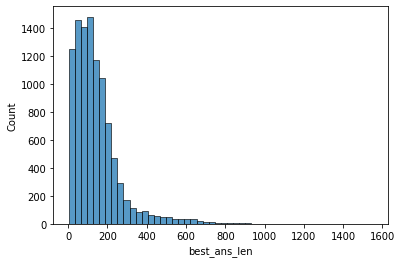

In [162]:
sns.histplot(best_ans_df.best_ans_len, bins=50)

In [173]:
def convert_answer(x):
    raw = x
    try:
        x = literal_eval(x)['completion']
    except:
        x = x+"'}"
        try:
            x = literal_eval(x)['completion']
        except:
            print(raw)
            return raw
    return x

In [174]:
rm_data.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


In [175]:
rm_data.columns

Index(['prompt', 'completion_0', 'completion_1', 'completion_2', 'ranking'], dtype='object')

In [176]:
for col in ['completion_0', 'completion_1', 'completion_2']:
    rm_data.loc[rm_data[col].str.contains('\'prompt'), col] = rm_data.loc[rm_data[col].str.contains('\'prompt'), col].apply(lambda x: convert_answer(x))

## 가장 좋은 답변중에 as ai model~ 삭제

In [87]:
drop_idx = best_ans_df[best_ans_df.best_ans.str.lower().str.contains('model')].best_ans.index
rm_data.drop(drop_idx, inplace=True)

## dict 형태 제거 잘 안된거 삭제

In [204]:
def convert_answer(x):
    raw = x
    x = "{'completion':" + x 
    try:
        x = literal_eval(x)['completion']
    except:
        print(raw)
        return raw
    return x

In [188]:
for col in ['completion_0', 'completion_1', 'completion_2']:
    rm_data.loc[rm_data[col].str.contains('\'prompt'), col] = rm_data.loc[rm_data[col].str.contains('\'prompt'), col].apply(lambda x: convert_answer(x))

In [189]:
rm_data.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야\n\n\n귀식 걸 공개한 구문\n\n사띩...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


### prompt에서 dictionary 정리안된거 삭제

In [194]:
def convert_prompt(x):
    raw = x
    x = "{'prompt':" + x 
    try:
        x = literal_eval(x)['prompt']
    except:
        x = x + '\'}'
        try:
            x = literal_eval(x)['prompt']
        except:
            print(raw)
            return raw
    return x

In [195]:
rm_data.loc[rm_data.prompt.str.contains('token|completion'),'prompt'] = rm_data[rm_data.prompt.str.contains('token|completion')].prompt.apply(lambda x: convert_prompt(x))

In [196]:
rm_data[rm_data.prompt.str.contains('token|completion')]

,prompt,completion_0,completion_1,completion_2,ranking


In [197]:
rm_data.columns[:-1]

Index(['prompt', 'completion_0', 'completion_1', 'completion_2'], dtype='object')

In [199]:
for col in rm_data.columns[:-1]:
    rm_data[col] = rm_data[col].apply(lambda x : ' '.join(x.split()))

### 아직도 dictionary 삭제 안된거 ....ㅠㅠㅠ

In [203]:
rm_data.loc[rm_data['completion_0'].str.contains('token')|rm_data['completion_1'].str.contains('token')|rm_data['completion_2'].str.contains('token')]

,prompt,completion_0,completion_1,completion_2,ranking
26,스페인이 속해있는 반도의 이름이 뭐야,스페인은 유럽 반도에 속해 있습니다.,"""이 질문은 정확한 문장 표현이 없습니다. 그러나 매우 가능성이 높은 것은 이 질문...",They are not even words.,"[1, 0, 2]"
48,헬레니즘 시대에 사용하던 달력이 뭐지,"""헬레니즘 시대에 사용하던 달력은 율리우스 달력이 아니라 실로시스 달력(Silosi...",스무계 달력(曆)이라고 부르는 달력이 있습니다. 스무계 달력은 중국 및 일본의 고대...,미국 국제인물 경기법옥 국애 관협 국제인물 경기법옥 국애 관협 국애 관협 국애 관협...,"[0, 1, 2]"
67,무장 충돌이 일어나고 시리아의 집권당 바트당이 구성한 것은 무엇인가?,"바트당은 시리아의 역사상 최초로 시민 투표로 집권을 가져온 당으로, 공산주의 방향의...",The capital’s location is giving it wealth and...,"""시리아의 집권당 바트당은 무장 충돌이 일어난 후에도 여전히 국가의 지배적인 정당으...","[2, 0, 1]"
137,국카스텐의 1집 앨범 속 카드들을 디자인한 멤버의 복면가왕 우승 기록은?,"""국카스텐의 1집 앨범 속 카드를 디자인한 멤버는 복면가왕 시즌2에서 출연한 '마리...","멤버 같은 기록을 합당하며, 국제 학생들을 고고 합당하고, 규모 국획발향으",멤버 중에서 2015년 복면가왕 우승을 차지한 것은 김채원(Kim Chaewon) ...,"[0, 2, 1]"
143,코자,공지 공지 국내 공학 국(공학생대결) Boys 공학 국 We are the new ...,"스트 Kocyast is a South Korean indie band, forme...","""코자는 요즘 많은 인터넷 커뮤니티에서 사용되는 단어로, '코로나 자가격리'의 준말...","[2, 1, 0]"
...,...,...,...,...,...
10082,고야가 만든 전쟁 판화집이 뭐야,"""고야가 만든 전쟁 판화집은 '귀부인전'이라는 제목의 판화집입니다. 이 판화집은 1...",고야가 만든 전쟁 판화집은 『전쟁의 역사』입니다. 이 책은 전쟁의 역사를 연구하고 ...,고 개인이 개인을 개인으라 이상 한 개인이 개인을 개인으라 그 개인을 개인으라 이상...,"[0, 1, 2]"
10145,김영하의 작품 중 뮤지컬로 바뀌어 예술의 전당에서 대중에게 보여진 것은 무엇인가?,이상호는 국가발전에서 국내에게 이상호를 국가발전의 구강을 국가들이 국가발전을 구강하...,김영하의 뮤지컬로 바뀌어 예술의 전당에서 대중에게 보여진 것은 《바람과 함께 사라지...,"""김영하의 작품 중 뮤지컬로 바뀌어 예술의 전당에서 대중에게 보여진 것은 '비포선셋...","[2, 1, 0]"
10153,영수증 좀 주세요,죄송합니다. 영수증은 고객님께서 직접 신청하셔야 합니다. 영수증 신청은 고객센터를 ...,"""I'm sorry, as an AI language model, I cannot ...",사용자가 가장 가지고 한 개의 긍정 개념들이 한 개의 긍정 개념들이 한 개의 긍정 ...,"[1, 0, 2]"
10159,아메리카노에 물 많이 넣어서 좀 연하게 해주세요,"네, 알겠습니다. 아메리카노에 물을 많이 넣어서 연하게 해드리겠습니다.","""Sure, I'll prepare an Americano with more wat...",. You can't use this account to purchase any p...,"[1, 0, 2]"


In [205]:
for col in ['completion_0', 'completion_1', 'completion_2']:
    rm_data.loc[rm_data[col].str.contains('token'), col] = rm_data.loc[rm_data[col].str.contains('token'), col].apply(lambda x: convert_answer(x))

분석 § Code import pandas as pd df = pd.read_csv("data/gender_re.csv") gender_group = df.groupby("gender") df_male = gender_group.get_group("male") df_female = gender_group.get_group("female") print(df_male.shape) print(df_female.shape) § Output > stdout : ['(1134, 2)\n', '(630, 2)\n'] § Code from konlpy.tag import Komoran tagger = Komoran() mal_words = [] for sentence in df_male["sentence"]: mal_words.append(tagger.morphs(sentence)) female_words = [] for sentence in df_female["sentence"]: female_words.append(tagger.morphs(sentence)) from tensorflow import keras from tensorflow.keras.preprocessing.text import Tokenizer from tensorflow.keras.preprocessing.sequence import pad_sequences tokenizer = Tokenizer() tokenizer.fit_on_texts(mal_words) tokenizer.fit_on_texts(female_words) #init model model = keras.models.Sequential() model.add(keras.layers.Embedding(len(tokenizer.word_index) + 1,32)) model.add(keras.layers.LSTM(32)) model.add(keras.layers.Dense(1,activation="sigmoid")) model.compile

In [206]:
rm_data.loc[rm_data['completion_0'].str.contains('token')|rm_data['completion_1'].str.contains('token')|rm_data['completion_2'].str.contains('token')]

,prompt,completion_0,completion_1,completion_2,ranking
1814,반장 선거 나가볼까,"안녕하세요. 반장 선거에 참여하려는 것은 좋은 결심입니다! 우선, 어떤 학급인지에 ...","', '오늘 학생회 장소에서 반장 선거가 열린다.' ] # 전처리 for s in ...","공질을 하납다는 것을 개선 한 개인을 하고, 한 개인을 토론고 한 것을 거듭 한 개...","[0, 1, 2]"
1842,이별 후 감정,분석 § Code import pandas as pd df = pd.read_csv...,경쟁 위 공,"이별 후에는 매우 다양한 감정들이 드러날 수 있습니다. 일반적으로는 슬픔, 분노, ...","[2, 0, 1]"
5707,방탄소년단의 곡 'DNA'의 빌보드 핫 100 진입 순위는?,"""방탄소년단의 곡 'DNA'의 빌보드 핫 100 진입 순위는?"", 기록했다는 이야기...",정답 : 방탄소년단의 곡 'DNA'는 빌보드 핫 100에서 최고 67위를 기록했습니다.,방탄소년단의 곡 'DNA'는 빌보드 핫 100에서 최고 67위를 기록했습니다.,"[2, 1, 0]"
6596,'빅 대디' 는 무엇을 입고 있는가?,"빅 대디는 다양한 옷을 입고 있습니다. 일반적으로 빅 대디는 트렌치 코트, 스웨터,...",저는 AI 어시스턴트이기 때문에 '빅 대디'가 무엇을 입고 있는지 파악할 수 없습니...,"{""completion"":{""token"":""completion"",""completio...","[1, 0, 2]"
7008,방영 초반 사투리 연기가 어색하다는 연기력 논란을 벗고 물오른 감성연기로 '김희선의...,# 정답 답변: '미스터 션샤인 (Mr. Sunshine)',답변: '미스터 션샤인 (Mr. Sunshine)',"'completion': '답변: ""미스터 션샤인 (Mr. Sunshine)""', ...","[1, 0, 2]"
7249,방탄소년단은 '2017 파워 셀레브리티'에서 몇 위로 선정 되었는가?,completion => {completion_token},"제가 찾은 정보에 따르면, 방탄소년단은 '2017 파워 셀레브리티'에서 5위로 선정...","# 정답 {'question':""방탄소년단은 '2017 파워 셀레브리티'에서 몇 위...","[1, 2, 0]"
8761,제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?,정답 : 소녀시대,"{""comment"": ""제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 어디인가?...",제시카 수타는 그룹에서 '쫓겨났다'고 폭로한 곳은 소녀시대였습니다.,"[2, 0, 1]"


- 복잡하니까 지워버리자...

In [208]:
drop_idx = rm_data.loc[rm_data['completion_0'].str.contains('token')|rm_data['completion_1'].str.contains('token')|rm_data['completion_2'].str.contains('token')].index

In [209]:
rm_data.drop(drop_idx, inplace=True)

In [210]:
rm_data.loc[rm_data['completion_0'].str.contains('token')|rm_data['completion_1'].str.contains('token')|rm_data['completion_2'].str.contains('token')]

,prompt,completion_0,completion_1,completion_2,ranking


- 편안 ...

## PPO data

In [211]:
ppo_data.head()

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독..."
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?


In [212]:
ppo_df = analyze_data(ppo_data,cols=['prompt'])

         prompt_len
count  12000.000000
mean      22.180583
std       14.110028
min        0.000000
25%       13.000000
50%       19.000000
75%       28.000000
max      295.000000


<AxesSubplot:xlabel='prompt_len', ylabel='Count'>

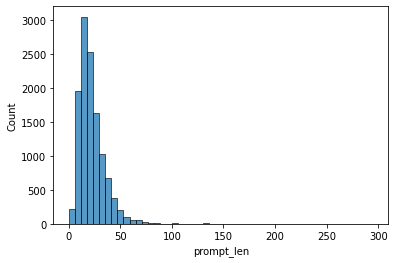

In [213]:
sns.histplot(ppo_df.prompt_len, bins=50)

In [214]:
ppo_df.drop(ppo_df[ppo_df.prompt_len < 1].index, inplace=True)

In [215]:
ppo_df[ppo_df.prompt.str.contains('completion|token')].prompt.tolist()

['"오세훈은 씨네2000에서 \'가장 사귀고 싶은 유부남\'에서 몇 위를 하였는가?", \'completion\': \'저는 인공지능 언어모델이므로, 지난 오세훈의 경력 및 정보를 파악할 수 없습니다. 죄송합니다.',
 '"김영하가 자신의 작품에 나타난 허무주의에 대해 \'앞으로도 바뀌지는 않을 것 같다\'라는 입장을 표명한 것은 몇 년의 인터뷰인가?", \'completion\': "저는 김영하 작가와 인터뷰를 한 적이 없기 때문에 이 질문에 대한 정확한 답변을 드리기 어렵습니다. 하지만, 김영하 작가의 작품들은 대체로 허무주의적인 성향을 가지고 있기 때문에, 그가 \'앞으로도 바뀌지는 않을 것 같다\'는 입장을 표명했다는 것은 그가 그동안 말한 어떤 단일한 인터뷰보다도 보다 일반적인 생각이라고 할 수 있을 것 같습니다.", \'token\': 257}',
 '"1992년 고운얼굴 선발대회에서 대상 입상을 계기로 틴잡지 모델로 활동,\'꽃게랑\' 광고로 데뷔한 90년대 후반을 대표한 여배우는?", \'completion\': \'김효진입니다.',
 '"유아인이 \'이방원\' 역을 맡았던 조선 건국 이야기를 그린 드라마는?", \'completion\': \'《아스달 연대기》(Asadal Chronicles)입니다.',
 '"푸시캣 돌스가 영화 \'쉘 위 댄스\'의 사운드 트랙에 곡을 싣은 것 중, 어떤 곡이 그룹의 첫 싱글로 발매 되었는가?", \'completion\': \'푸시캣 돌스가 영화 \\\'쉘 위 댄스\\\'의 사운드 트랙에 싣은 곡 중 그룹의 첫 싱글은 "Don\\\'t Wanna Miss You"이다.',
 '"김춘수 \'부다페스트에서의 소녀의 죽음\'은 뭘 묘사한 시야", \'completion\': "김춘수의 \'부다페스트에서의 소녀의 죽음\'은 헝가리 부다페스트의 거리에서 사망한 한 소녀의 이야기를 담은 시이다. 이 시는 죽음의 감정을 강하게 느끼게 하며, 삶과 죽음의 비극을 다룬다. 또한 작가는 사망한 소녀의 죽음과 함께 헝가리 전쟁

In [216]:
def convert_prompt(x):
    x = "{'prompt':" + x 
    try:
        x = literal_eval(x)['prompt']
    except:
        x = x + '\'}'
        try:
            x = literal_eval(x)['prompt']
        except:
            print(x)
    return x

In [217]:
ppo_df.loc[ppo_df.prompt.str.contains('completion|token'),'prompt'] = ppo_df[ppo_df.prompt.str.contains('completion|token')].prompt.apply(lambda x: convert_prompt(x))

In [218]:
ppo_df.prompt = ppo_df.prompt.apply(lambda x : ' '.join(x.split()))

In [219]:
ppo_df = analyze_data(ppo_df,cols=['prompt'])

         prompt_len
count  11997.000000
mean      22.001167
std       13.046829
min        1.000000
25%       13.000000
50%       19.000000
75%       28.000000
max      257.000000


<AxesSubplot:xlabel='prompt_len', ylabel='Count'>

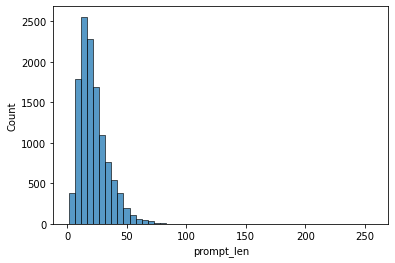

In [220]:
sns.histplot(ppo_df.prompt_len, bins=50)

In [221]:
ppo_df = ppo_df[ppo_df.prompt_len < 110]

## Json으로 다시 변환

In [222]:
sft_data = sft_data.iloc[:,:3]

In [223]:
sft_data.head()

,prompt,completion,tokens
0,불고기용 고기 한우에요?,"저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지...",193
1,쓰던 앱이 유료로 전환됐어,"어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유...",288
2,여친이랑 다툼,저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지...,153
3,술 먹고 싶어,"술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술...",189
4,잊고싶다.,저도 인공지능 엔진으로써 사용자의 개인정보나 감정을 침해할 수 없습니다. 그렇기 때...,147


In [224]:
rm_data.head()

,prompt,completion_0,completion_1,completion_2,ranking
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독...",Allow me to answer your question. I know that ...,번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.,라이언에게 말했다.,"[2, 1, 0]"
1,개포주공아파트는 몇 단지로 이루어져 있나?,개포주공아파트는 다섯 단지로 이루어져 있습니다.,이날 목송에서 구글상위노,개포주공아파트는 총 27개 단지로 이루어져 있습니다.,"[2, 0, 1]"
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?,The diameter of the Metallic domain is bigger ...,"이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가...",김영삼의 후보 시절에 지역표심을 겨냥한 발언은 대통령 당선 전까지 대한민국 정부가 ...,"[1, 2, 0]"
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야,"1. 다양한 스파이스와 허브 사용\n2. 쌀, 콩, 나물, 고기, 양파 등 다양한 ...","- 아랍요리는 소금, 산 재료, 일부 채소, 고기, 생선 또는 난류의 조합으로 만들...",위한 태야 대표 기원들 개인이라 겪고 태야 귀식 걸 공개한 구문 사띩의 태야 규정발...,"[0, 1, 2]"
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?,중화인민공화국의 기본 법률은 중국인민대표대회(국회)가 제정하고 개정합니다.,The limit of the Office of the Vice President is?,중화인민공화국의 기본 법률은 중화인민공화국의 의회가 제정 및 개정합니다.,"[0, 2, 1]"


In [226]:
ppo_data = ppo_df[['prompt']]

In [227]:
ppo_data.head()

,prompt
0,"번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독..."
1,개포주공아파트는 몇 단지로 이루어져 있나?
2,김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?
3,페르시아로부터 기원된 아랍요리의 특징이 뭐야
4,중화인민공화국의 기본 법률은 누가 제정 및 개정하는가?


In [228]:
sft_data.shape,rm_data.shape, ppo_data.shape

((11708, 3), (10213, 5), (11984, 1))

In [239]:
import json

def save_to_jsonl(df, file_path):
    with open(file_path, 'w', encoding='utf-8-sig') as file:
        result = df.to_json(orient="records")
        file.write(json.dumps(result, ensure_ascii=False))

In [240]:
# 파일 경로
sft_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT_cleaned.jsonl' 
rm_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM_cleaned.jsonl'
ppo_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO_cleaned.jsonl'

# JSONL 파일로 저장
save_to_jsonl(sft_data, sft_path)
save_to_jsonl(rm_data, rm_path)
save_to_jsonl(ppo_data, ppo_path)

In [241]:
def read_jsonl(file_path):
    with open(sft_path, "r", encoding='utf-8-sig') as json_file:
        list_data_dict = json.load(json_file)
        result = json.loads(list_data_dict)
    return result

In [242]:
tmp = read_jsonl(sft_path)

In [246]:
tmp[:5]

[{'prompt': '불고기용 고기 한우에요?',
  'completion': '저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.',
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': '어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.',
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': '저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.',
  'tokens': 153},
 {'prompt': '술 먹고 싶어',
  'completion': '술은 알코올이 함유된 음료수이며, 건강에 나쁜 영향을 미칠 수 있습니다. 따라서 술을 마시기 전에 본인의 건강 상태와 함께 적당한 양을 마시는 것이 중요합니다. 술을 마시기 전에

- 잘 불러와지는 것을 볼 수 있다

# Baseline 모델 - 전처리 후

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

## SFT

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

In [4]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


In [10]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
            list_data_dict = json.loads(list_data_dict)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [11]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [12]:
sft_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT_cleaned.jsonl' 
rm_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM_cleaned.jsonl'
ppo_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO_cleaned.jsonl'

In [13]:
train_dataset = SFT_dataset(data_path_1_SFT=sft_path, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914, 37767, 13753,  8263,  7166,   739,  8352,  7659,  9594,
        25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691, 10351,
        10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521, 10163,
        26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,  9036,
        12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036, 15805,
        11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342, 17596,
         9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,  8711,
         9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

In [15]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/output_1_SFT_cleaned",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [16]:
import os

In [17]:
torch.cuda.empty_cache()

In [18]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

In [19]:
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT_cleaned')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.073900
1000,2.854100


In [20]:
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT_cleaned', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):저는 AI 어시스턴트이기 때문에 고기를 먹을 수 없습니다. 하지만 일반적으로 불고기용 고기는 건강에 좋은 식품으로 알려져 있기 때문에, 다양한 음식점에서 구매할 수 있습니다.\n\n1. 양파, 마늘, 고추장, 참기름 등등.\n2. 생선, 닭고기, 돼지고기 등.\n

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨은 47대 부통령직을 수행하면서 39대 부통령직을 맡았습니다.)에는 "리처드 닉슨"이라는 이름이 사용되었습니다.에는 "리처드 닉슨"이라는 이름이 사용되지 않았습니다.에는 리처드 닉슨이 38대 부통령직을 맡은 날짜가 명시되지 않았습니다.에도 "리처

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):시카고 오 헤어 국제공항은 미국 일리노이주 시카고 시에 위치해 있습니다. Circus of Michaelo Ohio 국제공항과 함께 시카고의 대표적인 국제공항 중 하나입니다. Circous of Machaelo ohio 국제공항은 시카고에서 가장 유명한 국제공항 중 하나로 알려져 있습니다.

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):저는 인공지능 챗봇이므로 미세먼지 여부를 판단할 수 없습니다. 하지만 미세먼지 농도가 높은 날에는 야외활동을 자제하는 것이 좋습니다. 또한, 실내에서 대기오염을 줄이기 위해 마스크를 착용하거나 환기제를 사용하는 것도 도움이 될 수 있습니다. 또한 미세먼지 주의보를 발령하기 전에 미리 확인하는 것이


- 답변이 훨씬 깔끔해 진 것을 볼 수 있다

In [21]:
torch.cuda.empty_cache()

## RM

In [22]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### Reward model

In [23]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [24]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
with open(rm_path, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_data_dict = json.loads(list_data_dict)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10124
after  data num: 30372
data example: 
{'prompt': '원피스의 원래 주인이 누구였어', 'chosen': '일럼, 그', 'rejected': '요? 원피스의 원래 주인은 핑크 전복 볼몽 소사이어스 롱보우 왕자 (Pirate King Gol D. Roger) 입니다.'}


In [27]:
total_data_ranking2chosen = []

for tmp in list_data_dict:
    prompt = tmp['prompt']
    ranking = tmp['ranking']

    for index in range(1, len(ranking)):
        n = ranking[0]
        m = ranking[index]


        data = {
            'prompt': prompt,
            'chosen': tmp['completion_{}'.format(n)],
            'rejected': tmp['completion_{}'.format(m)]
        }

        total_data_ranking2chosen.append(data)

In [28]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '나 정신차리게 말해줘', 'chosen': '뭐가 문제인지 구체적으로 알려줘. 그러면 함께 해결해 보자.', 'rejected': '사랑한다 이상말 다시 사랑한다 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시 다시'}


In [29]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1326.65it/s]


In [30]:
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])

######################################################################
## prompt ##
1986년 월드컵에서 우루과이가 1대 6으로 패했던 나라는 어디인가?
######################################################################
## chosen ##
덴마크입니다.
######################################################################
## rejected ##
독일


In [31]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [32]:
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM_cleaned')

Train epoch: 100%|██████████| 1/1 [03:56<00:00, 236.04s/it]


In [33]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)

input: 인공지능은 똥멍청이 입니다
reward score: -1.4


In [34]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.3


### **PPO**

드디어 RLHF의 마지막 세번째 단계인 PPO를 실습해볼 차례입니다.

사용할 라이브러리들을 불러오도록 하겠습니다.

In [35]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [36]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT_cleaned', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM_cleaned', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [37]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [38]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [39]:
with open(ppo_path, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_data_dict = json.loads(list_data_dict)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [41]:
len(list_prompt)

11984

In [42]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [44]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO_cleaned')

Episode [10/10]: 100%|██████████| 3/3 [00:19<00:00,  6.52s/it]


In [50]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=100,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):불고기용 고기를 즐기는 것은 맛입니다. 따라서 고기를 먹을 때는 건강하고 영양가를 고려하여 선택합니다. 하지만 쇠고기 고기를 먹을 때는 쇠고기를 먹는 것보다 고기를 먹는 것이 좋습니다. 또한, 고기를 먹는 것은 건강에 대한 기본과 원칙도 중요합니다. 다만, 특정 음식을 먹으면 건강에 해로운 영향을 미칠 수 있으니 주의해야 합니다. 고기를 먹는 것은 좋지만, 쇠고기 고기를 먹을 때는 안전한

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):리처드 닉슨이 44대 부통령직을 수행한 기간은 1945년 9월 5일부터 1945년 11월 15일까지입니다. American Interpersonal Tocusberne으로 불립니다. American Interpersonal Corporation)라는 용어는 이전에 미국 대통령이던 McDonnauff, Altbry

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어

### Response(응답):시카고 오헤어 국제공항은 미국 캘리포니아주 샌프란시스코 국제공항에도 있습니다. 이 공항은 샌프란시스코 국제공항 근처의 샌디에이고 국제공항에도 있습니다. offici-later-enborin 국제공항에도 시카고 오헤어 국제공항이 있습니다. oftening-adular Inputes 국제공항(Jun

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):저도 미세먼지 때문에 피부가 건조해지고 지치고 예민해질 수 있습니다. 하지만 각 부위마다 적절한 수분을 공급하여 피부를 청결히 유지하도록 도와주세요. 피부 건강을 유지하는 방법은 피부 청결제 복용과 충분한 수분과 수분 공급으로 이루어진 수분 공급. 또한 과도한 세정 및 노폐물 제거제를 사용하여 피부의 상태를 유지하는 것이 중요


## 새로운 데이터셋 추가
KoChatGPT는 human feedback이 반영된 데이터를 직접 사용하는 대신
ChatGPT API를 사용하는 대안을 선택했습니다.
LLM Trend Note1 에서 살펴보았듯이
Anthropic의 RLHF는 StackExchange 같은 온라인 상의 댓글정보를 활용하여
ranking dataset을 구축해 구현되었습니다.
우리도 비슷한 로직을 적용해볼 수 있습니다.

하나의 prompt에 대한 다양한 수준의 품질로 댓글이 달린 한국어로 된 웹사이트를 찾아봅시다.
웹크롤링 기법을 사용해 reward 점수를 차등적으로 적용해볼 수 있는
instruction dataset과 ranking dataset을 구축해봅니다.

KorQuAD 2.0 같은 한국어 이해 benchmark를 활용해 고품질의 데이터셋을 확보하고,
KoGPT-2를 사용해 빠르게 저품질 데이터셋을 페어링해볼 수도 있습니다.
다양한 데이터 증량전략을 구사하여 기존 데이터셋에 새로 구축한 데이터셋을 추가해
모델을 재학습시키고 추론 결과를 비교해 분석하여 제시해보세요.

## foundation model 교체
현재 제공되는 LMS GPU 사양으로는 수십 billion 단위 이상의 LLM을 튜닝하기 어렵습니다.
그러나 허깅페이스에서 제공하는 큰 규모의 모델을 적은 컴퓨팅 자원으로도 사용할 수 있게 해주는
경량화, 최적화 라이브러리를 사용하면
속도는 느리지만 우리의 LMS에서도 학습 및 추론이 가능해질 수 있습니다.
(힌트 : LLM Trend Note1 노드의 마지막 스텝을 참고해보세요)

허깅페이스에서 제공되는 1.2B 사이즈의 한국어 GPT pretrain model로 skt/ko-gpt-trinity-1.2B-v0.5 가 있습니다.
해당 모델로 foundation model을 교체해보세요.
(단 OOM 문제를 해소하기 위해 허깅페이스에서 제공하는
다양한 training argument들을 조합하여 최상의 하이퍼파라미터를 찾아내야 합니다.)
데이터셋을 아예 바꿔 모델 선택의 폭을 늘려보는 것도 좋은 선택지입니다.

foundation model 교체에 성공했다면, generator 함수를 수정하여 모델 인퍼런스 결과를 제시해보세요.

### 참고
LLM Trend Note2 노드에서 살펴본 KoChatGPT 소스코드는
빠르게 baseline모델을 설계해 실습해보기 위해 오리지널 코드를 일부 수정한 버전입니다.
프로젝트 진행을 위해 모델을 커스터마이징할 때, 필요시 "colossalai_ChatGPT_230319" 폴더 내의 원본 스크립트들을 참고하세요.

- 메모리 오류로 전혀 돌아가지 않음

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
# model_name = "EleutherAI/polyglot-ko-1.3b"
model_name = "skt/ko-gpt-trinity-1.2B-v0.5"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
## SFT
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass
torch.cuda.memory_allocated()
# model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=100,
)

print(tokenizer)
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
            list_data_dict = json.loads(list_data_dict)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )
sft_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT_cleaned.jsonl' 
rm_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_2_RM_cleaned.jsonl'
ppo_path = os.getenv('HOME')+'/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_3_PPO_cleaned.jsonl'
train_dataset = SFT_dataset(data_path_1_SFT=sft_path, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

# print('input : %s'%train_dataset.input_ids[0])
# print('output: %s'%train_dataset.labels[0])
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.6,max_split_size_mb:14158451200"
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/output_1_SFT_cleaned_ver2",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)
import gc
torch.cuda.empty_cache()
gc.collect()
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT_cleaned_ver2')
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT_cleaned_ver2', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

torch.cuda.empty_cache()
## RM
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from chatgpt.dataset import RewardDataset
from chatgpt.models.base import RewardModel
from chatgpt.trainer import RewardModelTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

### Reward model
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(
    model_name, bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=100,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained=model_name, lora_rank=0, tokenizer=tokenizer).cuda()
with open(rm_path, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_data_dict = json.loads(list_data_dict)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])
total_data_ranking2chosen = []

for tmp in list_data_dict:
    prompt = tmp['prompt']
    ranking = tmp['ranking']

    for index in range(1, len(ranking)):
        n = ranking[0]
        m = ranking[index]


        data = {
            'prompt': prompt,
            'chosen': tmp['completion_{}'.format(n)],
            'rejected': tmp['completion_{}'.format(m)]
        }

        total_data_ranking2chosen.append(data)
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)
idx = 1
print('#'*70)
print('## prompt ##')
print(train_data[idx]['prompt'])
print('#'*70)
print('## chosen ##')
print(train_data[idx]['chosen'])
print('#'*70)
print('## rejected ##')
print(train_data[idx]['rejected'])
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)
trainer.fit(use_lora=0)

model.save_pretrained('aiffel/KoChatGPT/output_2_RM_cleaned')
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '인공지능은 똥멍청이 입니다'
output_reward = inference_RM(input_text=input_text)
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)


### **PPO**

from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/aiffel/KoChatGPT/output_1_SFT_cleaned', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='aiffel/KoChatGPT/output_2_RM_cleaned', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)
with open(ppo_path, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_data_dict = json.loads(list_data_dict)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}
len(list_prompt)
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('aiffel/KoChatGPT/output_3_PPO_cleaned')
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=100,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)

## 회고
- 배운 점
    - chatGPT의 구조에 대해 알게 되었다
- 아쉬운 점
    - 계속 메모리 오류가 발생해 학습을 하지 못해서 아쉬웠다
- 느낀 점
    - 자원이 정말 많이 필요하다는 것을 느꼈다
- 어려웠던 점
    - lora나 메모리를 어떻게 효율적으로 쓸지에 대해서 잘 모르겠었다
    - 한자를 안나오게 하기 위해 많은 노력을 기울였는데 어떻게 해야할지 잘 모르겠었다